### 之前看到一位兄dei搞cxk的人体关键点检测挺有趣，想着是不是可以基于人体关键点检测，加个一个差异计算可以评估青你选手主题曲的动作标准度。也不知道行不行先试试！
## 目的：
- 由于本人沉迷青你无法自拔，pick谢可寅跟安崎，想通过AI各种手段，包括NLP、CV等，看看我pick的选手是不是既有实力又有观众缘
- 说到实力，我打算使用关键点检测的模型，跟踪两位选手的骨骼走向，以安崎为标准，谢可寅为测试者，通过对比舞蹈得出实力评估值0-1
- 然后观众缘，主要通过微博的评论，经过统计与情感分析获得选手的主要关注内容以及大众对她的好感度
- 最后，据说风格迁移模型搞出来挺炫酷的，我也掺一脚

## 具体思路：

主要以安崎小甜心的主题曲直拍视频作为标准视频，谢可寅shaking的主题曲直拍视频作为测试视频

1. 将标准视频进行爬取，将视频逐帧读取成图片;
2. 由于图片背景光线不太利于关键点捕抓，利用deeplabv3p_xception65_humanseg进行抠图处理;
3. 基于pose_resnet50_mpii模型进行关键点检测并存储检测结果;
4. 然后对测试视频作同样处理存储检测结果;
5. 基于单通道的直方图对标准检测结果集以及测试检测结果集进行图片相似度计算，取结果均值作为选手的主题曲实力值;
6. 将获取的实力值合成到选手图片并输出
7. 爬取微博测试选手相关评论，统计高频词输出图
8. 对评论进行情感分析，输出总体评论积极与消极的对比饼图 


![示例](https://ai-studio-static-online.cdn.bcebos.com/2cc2c32beba74d638cc6a717bb58951b0dfe93bb1aa34117808838cc631aee23)![](https://ai-studio-static-online.cdn.bcebos.com/b9837de36aa348e695a6a5bea7a26666c85836428ab0429a8a33d6ab1ed7a830)


![](https://ai-studio-static-online.cdn.bcebos.com/c6b78c1b6688474e8c76cf93b64dbaa172021ef638ed48dcadc09d00c9cff9e8)

### 风格迁移
实现原视频画面风格转换成水墨风格，对视频的每一帧画面进行风格迁移处理，然后重新合成视频加上原视频音频后，重新输出

![](https://ai-studio-static-online.cdn.bcebos.com/0111c40988394fbbaf9c08702a00bf97a3f4de017f8a46c78f66894f2424ba1c) ![](https://ai-studio-static-online.cdn.bcebos.com/b60066bb579a44c1b2ca568499c6e0812688a493df6e4c8fa8e1c8f83a5bd783)


**成片**

![](https://ai-studio-static-online.cdn.bcebos.com/35ec87217aa644e3b53200e5fd5ef2b4995bc319df3b49f78976c92675034c60)






 





# 引入库准备

In [2]:
!pip install --upgrade paddlepaddle
!pip install --upgrade paddlehub
!pip install moviepy
!pip install pygame


Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 103.3MB 298kB/s ta 0:00:014
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 215kB 4.4MB/s eta 0:00:01
  Found existing installation: paddlehub 1.5.0
    Uninstalling paddlehub-1.5.0:
      Successfully uninstalled paddlehub-1.5.0
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 11.4MB 391kB/s eta 0:00:01


In [5]:
#相关库的导入
import os
import cv2
import paddlehub as hub
from moviepy.editor import *
from matplotlib import pyplot as plt
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from PIL import ImageFont, ImageDraw, Image
import requests



pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# !hub install pose_resnet50_mpii
# !hub install deeplabv3p_xception65_humanseg
!hub install stylepro_artistic

[==================================================] 100.00%
Uncompress /home/aistudio/.paddlehub/tmp/tmpsuwdvdb5/stylepro_artistic
[==================================================] 100.00%


In [6]:
# ## 模型安装
# ## 位置点预测模型
pose_resnet50_mpii = hub.Module(name="pose_resnet50_mpii") 
# ## 抠图模型
humanseg = hub.Module(name="deeplabv3p_xception65_humanseg")
## 风格转换模型
stylepro_artistic = hub.Module(name="stylepro_artistic")


[2020-05-05 12:27:53,703] [    INFO] - Installing pose_resnet50_mpii module
[2020-05-05 12:27:53,855] [    INFO] - Module pose_resnet50_mpii already installed in /home/aistudio/.paddlehub/modules/pose_resnet50_mpii
[2020-05-05 12:27:54,205] [    INFO] - Installing deeplabv3p_xception65_humanseg module
[2020-05-05 12:27:54,267] [    INFO] - Module deeplabv3p_xception65_humanseg already installed in /home/aistudio/.paddlehub/modules/deeplabv3p_xception65_humanseg
[2020-05-05 12:27:57,065] [    INFO] - Installing stylepro_artistic module
[2020-05-05 12:27:57,104] [    INFO] - Module stylepro_artistic already installed in /home/aistudio/.paddlehub/modules/stylepro_artistic


# 初始化数据集
搞一个青你主题曲标准视频作为数据集，选取比较优秀的选手安崎小甜心的主题曲直拍作为参考视频，具体爬取微博小视频的方式涉及版权不作详细介绍


In [ ]:

def download_video(url,path):
    # url 为视频下载地址
    # video保存地址
    headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'zh-CN,zh;q = 0.9'
        }
    mp4_info = requests.get(url=aq_url, headers=headers, stream=True, verify=False).content
    with open(path, "wb") as f:
        f.write(mp4_info)
    f.close

# aq_url = 'http://f.video.weibocdn.com/004tUGlvgx07Cqf0sEtG010412012bBR0E010.mp4?label=mp4_hd&template=352x640.25.0&trans_finger=1621fcd5d40969f1c74e6b06e52fcd54&Expires=1588498809&ssig=kFgW8J7KpP&KID=unistore,video'
# download_video(aq_url,'video/aq_base.mp4')


# 处理视频

将视频逐帧读取成图片


In [20]:
def CutVideo2Image(video_path, img_path):
    "读取视频，获取每帧画面，输出为图片"
    "video_path：输入视频路径"
    "img_path：输出图片路径"
    cap = cv2.VideoCapture(video_path)
    index = 0
    global size_y ,size_x
    while(True):
        ret,frame = cap.read() 
        if ret and index < 2000:
            # cv2.imwrite(img_path + '%d.jpg' % index, frame)
            index += 1
        else:
            break
        size_x = frame.shape[0]
        size_y = frame.shape[1]
    cap.release()
    print('Video cut finish, all %d frame' % index)
    print("imge size:x is {1},y is {0}".format(size_x,size_y))
   




#  进行一张图片的人体关键点的预测与划线
`作用`：确定数据格式，保证输出样式

 `功能`：，在预测图片的基础上进行划线连接

**改动參数,将读进来的是BGR格式转为RGB**

## 处理图片背景

由于视频的光线色彩有点炫酷，所以处理一下图片进行抠图，然后合成白底输出

In [ ]:
import os

# 抠图
def delete_bg(path):
    "抠图去除多余背景"
    "path:需要抠图的图片目录"
    img_list= [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]
    num=100 #定义每组包含的元素个数
    for i in range(0,len(img_list),num):
        humanseg.segmentation(data={"image":img_list[i:i+num]},output_dir='h_out/')

 #   results = humanseg.segmentation(data={"image":img_list})

# delete_bg('data/img/base')

In [ ]:
from PIL import Image 

# 合成图片
## base_image_path:背景路径
## fore_image_path：前景路径
## save_path： 输出图片路径
## is_resize 是否大小统一
def composition_img(base_image_path,fore_image_path,save_path,is_resize):
    base_image = Image.open(base_image_path).convert('RGB')
    if is_resize== True:
        fore_image = Image.open(fore_image_path).resize(base_image.size)
    else:
        fore_image = Image.open(fore_image_path)
        # 图片加权合成
    scope_map = np.array(fore_image)[:,:,-1] / 255
    scope_map = scope_map[:,:,np.newaxis]
    scope_map = np.repeat(scope_map, repeats=3, axis=2)#表示将矩阵沿着每个元素复制3次
    res_image = np.multiply(scope_map, np.array(fore_image)[:,:,:3]) + np.multiply((1-scope_map), np.array(base_image))
        
    #保存图片
    res_image = Image.fromarray(np.uint8(res_image))
    res_image.save(save_path)


In [ ]:

# 添加白色背景转成jpg
def add_white_bg(path,bgout_path,output_path):
    
    num = os.listdir(path)

    for i in range(0,len(num)-1):
        img_black = np.zeros((size_x,size_y,3), np.uint8)
        img_black.fill(255)
        img_black_path =bgout_path + str(i) + ".jpg"
        cv2.imwrite(img_black_path,img_black)

    for i in range(0,len(num)-1):
        # 合成图片
        composition_img(img_black_path,path+str(i)+'.png',output_path+str(i)+'.jpg',True)
 

# add_white_bg('h_out/','data/img/bgout/','data/img/bgres/')

## 使用关键点检测模型进行画点线输出

### 定义数据转化格式
`函数change_data(result) `

`输入参数`：人体骨骼关键点检测模型的输出结果

 `输出参数`: 关于人体关键点的全局变量
 
`函数功能`	：`**将位置点预测模型输出的数据形式转为预期的数据**

In [ ]:

def change_data(result):
  global left_ankle,left_knee,left_hip,right_hip,right_knee,right_ankle,pelvis,thorax,upper_neck
  global right_wrist,right_elbow,right_shoulder,left_shoulder,left_elbow,left_wrist,head_top

  left_ankle = result['data']['left_ankle']
  left_knee = result['data']['left_knee']
  left_hip = result['data']['left_hip']
  right_hip = result['data']['right_hip']
  right_knee = result['data']['right_knee']
  right_ankle = result['data']['right_ankle']
  pelvis = result['data']['pelvis']
  thorax = result['data']['thorax']
  upper_neck = result['data']['upper neck']
  head_top = result['data']['head top']
  right_wrist = result['data']['right_wrist']
  right_elbow = result['data']['right_elbow']
  right_shoulder = result['data']['right_shoulder']
  left_shoulder = result['data']['left_shoulder']
  left_elbow = result['data']['left_elbow']
  left_wrist = result['data']['left_wrist']


### 将位置点连线
格式
`cv2.circle(img, point, point_size, point_color, thickness)`

`输入参数`:`predict_img_path`为输入图片的地址

`输出参数`：由两个分别是将人体关键点的线画在`空白背景上`/`模型输出的图片上`

功能：`给图片划线`并写入将图片按一定顺序保存保存


In [ ]:
def write_line(predict_img_path,output_path):
    global count_frame 
    print(predict_img_path)
    img = cv2.imread(predict_img_path)
    thickness = 2
    point_color = (0, 255, 0) # BGR  
    # 格式cv2.circle(img, point, point_size, point_color, thickness)
    cv2.line(img, (head_top[0],head_top[1]), (upper_neck[0],upper_neck[1]), point_color, 1)
    cv2.line(img, (upper_neck[0],upper_neck[1]), (thorax[0],thorax[1]), point_color, thickness)
    cv2.line(img, (upper_neck[0],upper_neck[1]), (left_shoulder[0],left_shoulder[1]), point_color, thickness)
    cv2.line(img, (upper_neck[0],upper_neck[1]), (right_shoulder[0],right_shoulder[1]), point_color, thickness)
    cv2.line(img, (left_shoulder[0],left_shoulder[1]), (left_elbow[0],left_elbow[1]), point_color, thickness)
    cv2.line(img, (left_elbow[0],left_elbow[1]), (left_wrist[0],left_wrist[1]), point_color, thickness)
    cv2.line(img, (right_shoulder[0],right_shoulder[1]), (right_elbow[0],right_elbow[1]), point_color, thickness)
    cv2.line(img, (right_elbow[0],right_elbow[1]), (right_wrist[0],right_wrist[1]), point_color, thickness)
    cv2.line(img, (left_hip[0],left_hip[1]), (left_knee[0],left_knee[1]), point_color, thickness)
    cv2.line(img, (left_knee[0],left_knee[1]), (left_ankle[0],left_ankle[1]), point_color, thickness)
    cv2.line(img, (right_hip[0],right_hip[1]), (right_knee[0],right_knee[1]), point_color, thickness)
    cv2.line(img, (right_knee[0],right_knee[1]), (right_ankle[0],right_ankle[1]), point_color, thickness)
    cv2.line(img, (thorax[0],thorax[1]), (left_hip[0],left_hip[1]), point_color, thickness)
    cv2.line(img, (thorax[0],thorax[1]), (right_hip[0],right_hip[1]), point_color, thickness)
    true_count = count_frame //2
    # pose_img_path = "data/img/pose_frame/" + str(true_count) +".jpg"
    # img_black_path = "data/img/black_frame/" + str(true_count) + ".jpg"
    # if (count_frame %2):
    #     cv2.imwrite(output_path,img)
    # else:
    #     cv2.imwrite(img_black_path,img)
    cv2.imwrite(output_path+ str(true_count) +".jpg",img)
    count_frame = count_frame +1



### 连接监测点进行画线并输出

In [ ]:
def GetOutputPose(frame_path,output_black_path,output_pose_path):
    "输入需要进行关键点检测的图片目录，进行检测后分别输出原图加线的图片以及只有关键点连线的图"
    "black_path:只有关键点连线的图片目录"
    "frame_path:需要处理的图片目录"
    "output_pose_path:带原图加连线的图片目录"
    # 配置
    num = os.listdir(frame_path)
    for i in range(0,len(num)-1):
        img_black = np.zeros((size_x,size_y,3), np.uint8)
        img_black.fill(255)
        img_black_path =output_black_path + str(i) + ".jpg"
        cv2.imwrite(img_black_path,img_black)
    for i in range(0,len(num)-1):
        path_dict = frame_path + str(i) + ".jpg"
        input_dict = {"image":[path_dict]}
        print("This is OutputPose {} pictrue".format(i))
        # img_black_path = "data/img/black_frame/" + str(i) + ".jpg"
        results = pose_resnet50_mpii.keypoint_detection(data=input_dict)
        for result in results:
            change_data(result)
            write_line(path_dict,output_pose_path)
            write_line(img_black_path,output_black_path)




# 转换风格
将安崎小甜心的主题曲直拍视频专程水墨画风格

## 定义转换风格方法
输入需要进行风格迁移的图片路径列表，批量转换并输出

In [15]:
def change_style(img_list,output_dir):
    """
    调用模型进行风格转换
    img_list: 需要转换的图片对象集合
    output_dir:图片输出目录
    """
    print(img_list)

    result = stylepro_artistic.style_transfer(
            paths=img_list,
            # use_gpu=True,
            visualization=True,
            output_dir=output_dir,
            alpha=0.5
        )     
    



def get_img_list(frame_path):
    """
    组装转换风格imglist
    frame_path：需要转换风格的原图目录
    """
    num = os.listdir(frame_path)
    img_list=[]
    for i in range(0,len(num)-1):
        img_path =frame_path + str(i) + ".jpg"
        img={}
        styles=['work/style/timg3.jpg']
        img['styles']=styles
        img['content']=img_path
        img_list.append(img)
    return img_list




## 视频合成
将风格迁移完的美美的图片重新组装成视频并输出

In [17]:
def comp_video(comb_path):
    """
    视频合成
    comb_path: 合成图片所在目录
    """
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video_tmp_name = comb_path.split("/")[2]
    video_name = "video/" + str(video_tmp_name) + ".mp4"
    files = os.listdir(comb_path)
    out = cv2.VideoWriter(video_name,fourcc,30.0,(size_y, size_x))
    # 排序
    files = sorted(files, key=lambda x: os.path.getmtime(os.path.join(comb_path, x)))
    print("一共有{}帧图片要合成".format(len(files)))
    for i in range(len(files)):
        img = cv2.imread(comb_path+files[i])
        out.write(img)    # 保存帧
    out.release()




## 视频音频合成
将原本视频的音频合到新风格的视频上

In [18]:


def getMusic(video_name):

    """

    获取指定视频的音频

    """

    # 读取视频文件

    video = VideoFileClip(video_name)

    # 返回音频

    return video.audio


def addMusic(video_name, audio,output_video):

    """实现混流，给video_name添加音频"""

    # 读取视频

    video = VideoFileClip(video_name)

    # 设置视频的音频

    video = video.set_audio(audio)

    # 保存新的视频文件

    video.write_videofile(output_video)
    


# 动作评估

上面我们已经生成了青春有你2的主题曲标准舞蹈的关键点画线集合，接下来，我们需要实现对比标准舞蹈动作以及测试舞蹈动作，计算每一帧图片的相似度，然后通过均值计算获取选手主题曲的舞蹈实力分数


## 相似值计算
基于直方图计算两个图片之间的相似度

In [ ]:
import cv2

# 计算单通道的直方图的相似值
def calculate(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree

## 将实力值合成到测试选手的图片上面

In [ ]:
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
from PIL import ImageDraw , ImageFont
 
def draw_text(bg_path,text,output_path):
    """
    实现图片上面叠加中文
    bg_path：需要加中文的图片
    text: 添加的中文内容
    output_path： 合成后输出的图片路径
    """
    
    im = Image.open(bg_path)
    draw = ImageDraw.Draw(im)
    fnt = ImageFont.truetype(r'fonts/SimHei.ttf',32)
    draw.text((100, 600), text, fill='red', font=fnt)
    im.show()
    im.save(output_path)


# 分析测试选手的大众好感度
主要是基于LSTM模型对微博评论进行情感分析
1.爬取与测试选手相关微博评论
2.训练模型
3.得出选手好感度以及搜索输出选手话题词云


In [ ]:
!pip install pyquery

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 5.7MB 58.8MB/s eta 0:00:01


## 爬取微博评论数据

In [ ]:
import requests
from pyquery import PyQuery as pq
import time
from urllib.parse import quote
import os

def get_page(page): 
    """
    通过微博api获取微博数据
    page: 分页页数
    """
    headers = {
        'Host': 'm.weibo.cn',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest',
    }

    url = 'https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D'+quote(m)+'&page_type=searchall&page='+str(page)#将你检索内容转为超链接
    print(url)
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            print(page)
            return response.json()
    except requests.ConnectionError as e:
        print('Error', e.args)


def parse_page(json):
    f_comments=open('comment/comment.txt','a')
    f_user=open('comment/weibo_user.txt','a')

    if json:
        items = json.get('data').get('cards')
        for i in items:
      
            item = i.get('mblog')
            if item == None:
                continue

            weibo = {}
            weibo['id'] = item.get('id')
            weibo['text'] = pq(item.get('text')).text()
            weibo['name'] = item.get('user').get('screen_name')
            if item.get('longText') != None :#要注意微博分长文本与文本，较长的文本在文本中会显示不全，故我们要判断并抓取。
                weibo['longText'] = item.get('longText').get('longTextContent')
            else:
                weibo['longText'] =None
            # print(weibo['name'])
            # print(weibo['text'])
            if weibo['longText'] !=None:
                f_comments.write(weibo['longText'])
                
            f_comments.write(weibo['text']+'\n')
            f_user.write(weibo['name']+'\n')
              
            #     yield weibo
    f_comments.close()
    f_user.close()

if __name__ == '__main__':
    m = '谢可寅'
    n = 50
  
    for page in range(1,n+1):
        time.sleep(1)         #设置睡眠时间，防止被封号
        json = get_page(page)
        parse_page(json)



https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=1
1
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=2
2
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=3
3
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=4
4
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=5
5
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=6
6
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%E8%B0%A2%E5%8F%AF%E5%AF%85&page_type=searchall&page=7
7
https://m.weibo.cn/api/container/getIndex?containerid=100103type%3D1%26q%3D%

## 清洗数据

In [ ]:
import re #正则匹配
import jieba #中文分词

#去除文本中特殊字符
def clear_special_char(content):
    '''
    正则处理特殊字符
    参数 content:原文本
    return: 清除后的文本
    '''
    f_clear = open('comment/clear_comment.txt','a')
    clear_content = re.findall('[\u4e00-\u9fa5a-zA-Z0-9]+',content,re.S)   #只要字符串中的中文，字母，数字
    str=','.join(clear_content)
    f_clear.write(str+'\n')
    f_clear.close
    return str

def fenci(content):
    '''
    利用jieba进行分词
    参数 text:需要分词的句子或文本
    return：分词结果
    '''
    jieba.load_userdict(r"dic/user_dic.txt")
    seg_list = jieba.cut(content)
    return seg_list




def stopwordslist():
    '''
    创建停用词表
    参数 file_path:停用词文本路径
    return：停用词list
    '''
    stopwords = [line.strip() for line in open('work/stopwords.txt',encoding='UTF-8').readlines()]
    acstopwords=['哦','因此','不然','谢可寅','超话']
    stopwords.extend(acstopwords)
    return stopwords

import pandas as pd

def movestopwords(sentence_depart,stopwords):
    '''
    去除停用词,统计词频
    参数 file_path:停用词文本路径 stopwords:停用词list counts: 词频统计结果
    return：None
    '''
    segments = []
   
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                # outstr += word
                # outstr += " "
                segments.append(word)
   
    return segments





In [ ]:
# 下载中文字体

# 将字体文件复制到matplotlib字体路径
!cp fonts/SimHei.ttf /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/
# # 一般只需要将字体文件复制到系统字体目录下即可，但是在aistudio上该路径没有写权限，所以此方法不能用
!cp fonts/SimHei.ttf .fonts
# !rm -rf .cache/matplotlib
!rm -rf .cache/matplotlib

from matplotlib.font_manager import fontManager


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 统计数据

2020-05-05 00:21:45,571-WARNING: No handles with labels found to put in legend.


[('青春有你', 460), ('喻言', 196), ('虞书欣', 181), ('金子涵', 172), ('刘雨昕', 168), ('孔雪儿', 155), ('赵小棠', 151), ('许佳琪', 142), ('直拍', 135), ('喜欢', 125)]
{'青春有你': 460, '喻言': 196, '虞书欣': 181, '金子涵': 172, '刘雨昕': 168, '孔雪儿': 155, '赵小棠': 151, '许佳琪': 142, '直拍': 135, '喜欢': 125}


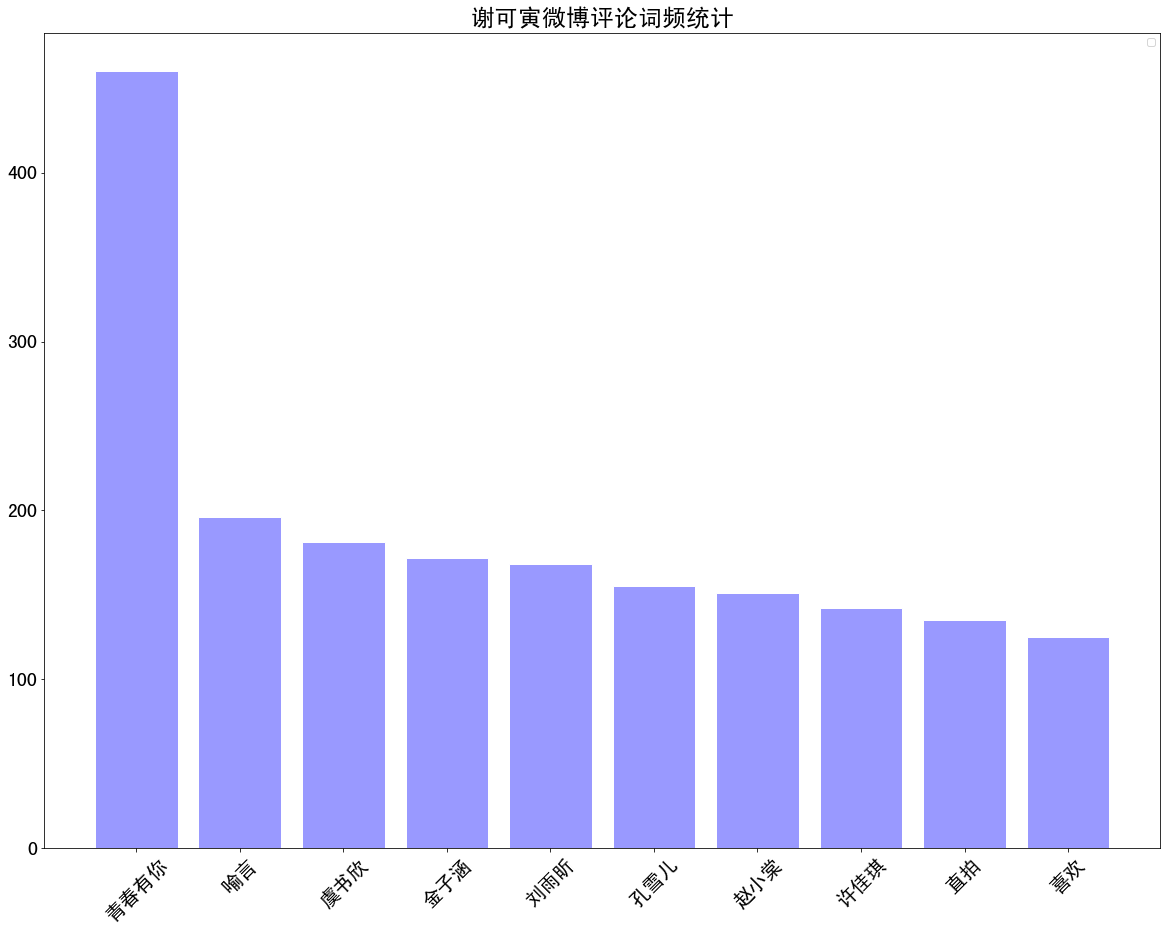

In [ ]:
import collections 

def drawcounts(segments):
    '''
    绘制词频统计表
    参数 counts: 词频统计结果 num:绘制topN
    return：none
    '''
    # 词频统计
    word_counts = collections.Counter(segments) # 对分词做词频统计
    word_counts_top10 = word_counts.most_common(10) # 获取前10最高频的词
    print (word_counts_top10) 
    dic=dict(word_counts_top10)
    print(dic)
    x_values=[]
    y_values=[]
    for k in dic: 
        x_values.append(k)
        y_values.append(dic[k])
    # 设置显示中文

    plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体

    plt.figure(figsize=(20,15))

    plt.bar(range(len(y_values)), y_values,color='r',tick_label=x_values,facecolor='#9999ff',edgecolor='white')

    # 这里是调节横坐标的倾斜度，rotation是度数，以及设置刻度字体大小
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend()
    plt.title('''谢可寅微博评论词频统计''',fontsize = 24)
    plt.savefig('highwords.jpg')
    plt.show()
    return word_counts



if __name__ == '__main__':

    stopwords=stopwordslist()

    f = open(r"comment/comment.txt")
    line = f.readline()
    segments=[]
    while line:
        line = f.readline()
        clear_line=clear_special_char(line)
        seg_list= fenci(clear_line)
        segments_list=movestopwords(seg_list,stopwords)
        segments.extend(segments_list)
    f.close()
    drawcounts(segments)

  

## 情感分析

对评论进行情感分析，并绘制饼图

In [92]:
!pip uninstall -y pyecharts
!pip install pyecharts

# !pip install pyecharts==0.5.10 -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
  Using cached https://mirrors.tuna.tsinghua.edu.cn/pypi/web/packages/8b/87/d358d00c8e7837da835869afa34cf556dc743a20d92d67abe02529c7b1d8/pyecharts-1.7.1-py3-none-any.whl


In [97]:
# from pyecharts import Pie
# from pyecharts.charts.basic_charts.pie import Pie

from pyecharts.charts import Pie
from pyecharts import options as opts
def draw_pie(data,labels):
    """
    绘制饼图
  
    """
    data_pie = [list(i) for i in zip(labels,data)]

 # 创建实例对象
    pie = Pie(init_opts=opts.InitOpts(width='1000px',height='600px'))
    # 添加数据
    pie.add(series_name="情感类型",data_pair=data_pie)
    # 设置全局项
    pie.set_global_opts(title_opts=opts.TitleOpts(title="谢可寅好感分析",pos_left='center',pos_top=20))
    #设置每项数据占比
    pie.set_series_opts(tooltip_opts=opts.TooltipOpts(trigger='item',formatter="{a} <br/> {b}:{c} ({d}%)"))
    pie.render("pie_charts.html")





In [60]:
!hub install senta_lstm
senta = hub.Module(name="senta_lstm")


Module senta_lstm already installed in /home/aistudio/.paddlehub/modules/senta_lstm


[2020-05-05 00:44:32,581] [    INFO] - Installing senta_lstm module
[2020-05-05 00:44:32,617] [    INFO] - Module senta_lstm already installed in /home/aistudio/.paddlehub/modules/senta_lstm
[2020-05-05 00:44:34,538] [ WARNING] - Parameter module_dir is deprecated, please use directory to specify the path


In [98]:
if __name__ == '__main__':

    f = open(r"comment/clear_comment.txt")
    line = f.readline()
    comments=[]
    while line:
        comments.append(line)
        line = f.readline()

    f.close()
    input_dict = {"text": comments}
    results = senta.sentiment_classify(data=input_dict,batch_size=5)
    positive_num=0
    negative_num=0
    for result in results:
        if result['sentiment_key'] == 'positive':
            positive_num+=1
        else:
            negative_num+=1

    print("total:%f,pos:%f,neg:%f"%(len(results),positive_num,negative_num))
    data=[positive_num,negative_num]
    labels=['积极评论','消极评论']
    draw_pie(data,labels)


total:2505.000000,pos:1206.000000,neg:1299.000000


# 具体调用

1. 生成标准选手的关键点划线图
2. 生成测试选手的关键点划线图
3. 评估测试选手主题曲实力
4. 计算相似度均值并输出图片结果


In [ ]:
if __name__ == "__main__":

    # 生成标准选手的关键点划线图
    CutVideo2Image('video/aq_base4.mp4','work/aq/base/')
    delete_bg('work/aq/base/')
    add_white_bg('h_out/','work/aq/bgout/','work/aq/bgres/')
    count_frame = 0
    GetOutputPose('work/aq/bgres/','work/aq/black_frame/','work/aq/pose_frame/')
  
    # 生成测试选手的关键点划线图
    CutVideo2Image('video/xky_base1.mp4','work/test/base/')
    count_frame = 0
    GetOutputPose('work/test/base/','work/test/black_frame/','work/test/pose_frame/')

    # 评估测试选手主题曲实力
    test_path = 'work/test/black_frame/'
    standard_path='work/aq/black_frame/'
    cal=[]
    num = os.listdir(test_path)
    for i in range(0,len(test_path)-1): 
        imgobj1 = cv2.imread(test_path+str(i)+'.jpg')
        imgobj2 = cv2.imread(standard_path+str(i)+'.jpg')
        cal.append(calculate(imgobj1,imgobj2))

    # 计算均值并输出图片结果
    power_val = '实力评估值为：%3.2f'%(np.mean(cal))
    draw_text('work/test/base/100.jpg',power_val,'result_test.jpg')






[2020-05-04 21:35:38,167] [    INFO] - Installing stylepro_artistic module
[2020-05-04 21:35:38,185] [ WARNING] - /home/aistudio/.paddlehub/modules/stylepro_artistic/module_desc.pb does not exist, the module will be reinstalled
[2020-05-04 21:35:40,432] [   ERROR] -  
[2020-05-04 21:35:40,433] [   ERROR] - %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[2020-05-04 21:35:40,434] [   ERROR] - %                                  %
[2020-05-04 21:35:40,435] [   ERROR] - %  The version of PaddlePaddle or  %
[2020-05-04 21:35:40,436] [   ERROR] - %  ===> PaddleHub can not match m  %
[2020-05-04 21:35:40,436] [   ERROR] - %  ===>odule, please upgrade your  %
[2020-05-04 21:35:40,437] [   ERROR] - %  ===> PaddlePaddle or PaddleHub  %
[2020-05-04 21:35:40,438] [   ERROR] - %  ===> according to the form bel  %
[2020-05-04 21:35:40,438] [   ERROR] - %  +-----------------------------  %
[2020-05-04 21:35:40,439] [   ERROR] - %  ===>---+----------+-----------  %
[2020-05-04 21:35:40,440] [   ERROR] - %  ===>-

RuntimeError: The version of PaddlePaddle or PaddleHub can not match module, please upgrade your PaddlePaddle or PaddleHub according to the form below.
+--------------------------------+----------+------------------+------------------+
|          [1;32mResourceName[0m          | [1;32mVersion[0m  |   [1;32mPaddlePaddle[0m   |    [1;32mPaddleHub[0m     |
+--------------------------------+----------+------------------+------------------+
|       [1;33mstylepro_artistic[0m        |  1.0.0   |      >1.6.2      |      >1.6.0      |
+--------------------------------+----------+------------------+------------------+


## 转换水墨画风格

In [21]:
if __name__ == "__main__":
      ## 转换风格
    change_style(get_img_list('work/aq/bgres/'),'work/aq/style_img/')
    comp_video('work/aq/style_img/')
    addMusic('video/style_img.mp4',getMusic('video/aq_base4.mp4'),'video/voice_frame2.mp4')

Video cut finish, all 186 frame
imge size:x is 352,y is 640
一共有184帧图片要合成


chunk:  71%|███████   | 97/137 [00:00<00:00, 285.31it/s, now=None]

Moviepy - Building video video/voice_frame2.mp4.
MoviePy - Writing audio in voice_frame2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video/voice_frame2.mp4



t:  30%|███       | 56/184 [00:00<00:00, 551.63it/s, now=None]                                                               


Moviepy - Done !
Moviepy - video ready video/voice_frame2.mp4
